In [118]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tqdm.notebook import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner as kt
from keras.utils import to_categorical
import matplotlib.patches as patches


# Problem

Train a CNN model that can predict / classify images based on whether they have cancer or not. Also explore how different hyperparameters affect model performance

In [119]:
# Load the train and sample submission CSV files
train_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
sample_submission_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')

# Display the first few rows of the train dataframe
train_df.head()


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [120]:
# Check for missing values and data types
train_df.info()

# Check the distribution of labels (1 = cancer, 0 = non-cancer)
train_df['label'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


label
0    130908
1     89117
Name: count, dtype: int64

# Some EDA to visualize what the images look like

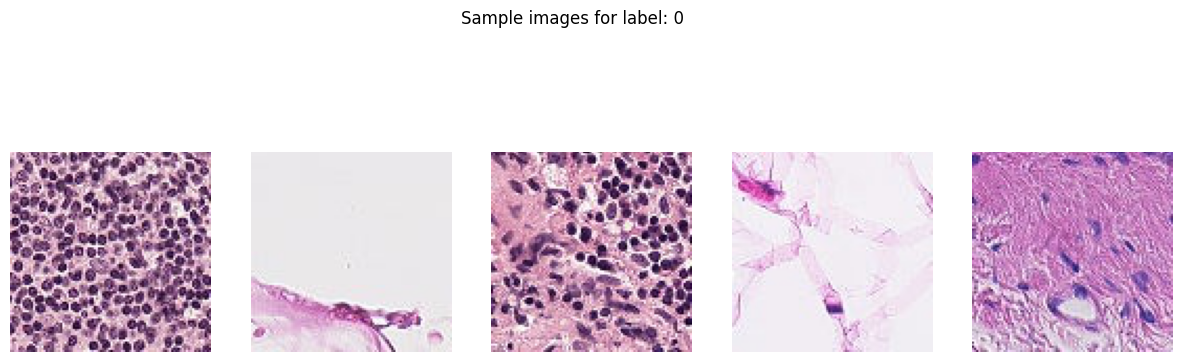

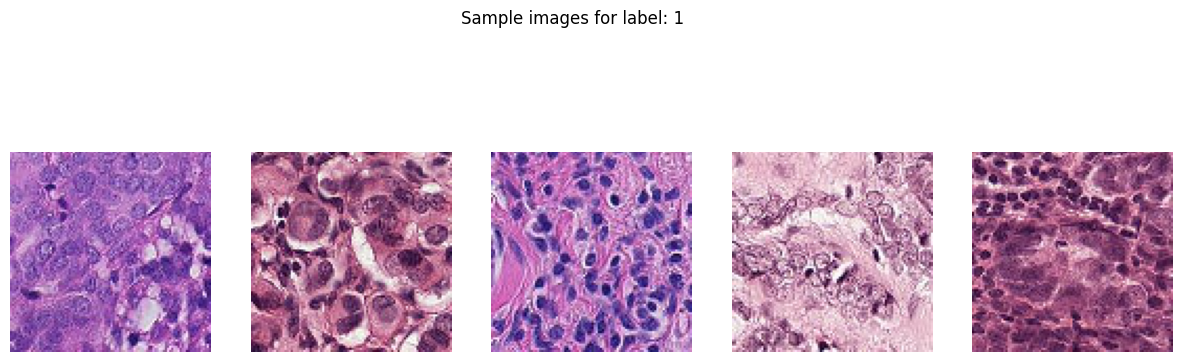

In [121]:
# Set the path to the train images
train_img_path = '/kaggle/input/histopathologic-cancer-detection/train'

# Visualize a few images from each class (0 = non-cancer, 1 = cancer)
def plot_sample_images(df, label, num_samples=5):
    sample_df = df[df['label'] == label].sample(num_samples)
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    
    for img_id, ax in zip(sample_df['id'], axes):
        img = Image.open(os.path.join(train_img_path, img_id + '.tif'))
        ax.imshow(img)
        ax.axis('off')
    plt.suptitle(f'Sample images for label: {label}')
    plt.show()

# Plot sample images for non-cancer (label = 0)
plot_sample_images(train_df, label=0)

# Plot sample images for cancer (label = 1)
plot_sample_images(train_df, label=1)


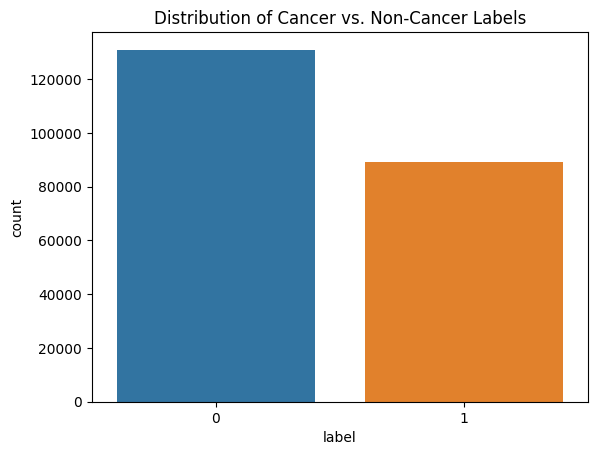

Image size: (96, 96)


,Height,Width
count,100.0,100.0
mean,96.0,96.0
std,0.0,0.0
min,96.0,96.0
25%,96.0,96.0
50%,96.0,96.0
75%,96.0,96.0
max,96.0,96.0


In [122]:
# Plot the label distribution
sns.countplot(x='label', data=train_df)
plt.title('Distribution of Cancer vs. Non-Cancer Labels')
plt.show()

# Check the size of a few images
img_sample = Image.open(os.path.join(train_img_path, train_df['id'][0] + '.tif'))
print(f"Image size: {img_sample.size}")  # Output the size of an image

# You could also check if all images have the same size using cv2
image_sizes = []
for img_id in train_df['id'].sample(100):  # Check a sample of 100 images
    img = cv2.imread(os.path.join(train_img_path, img_id + '.tif'))
    image_sizes.append(img.shape[:2])

# Convert the image sizes to a DataFrame for better visualization
image_sizes_df = pd.DataFrame(image_sizes, columns=['Height', 'Width'])
image_sizes_df.describe()


# Exploring various models and parameters

In [123]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the train CSV file
train_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

# Sample approximately 3,000 samples for faster experimentation
train_sample_df, _ = train_test_split(train_df, train_size=3000, stratify=train_df['label'], random_state=42)

# Display the number of samples in the smaller dataset
print(f"Number of samples in the training subset: {len(train_sample_df)}")

# Split the data into training and validation sets (80% training, 20% validation)
train_data, val_data = train_test_split(train_sample_df, test_size=0.2, stratify=train_sample_df['label'], random_state=42)

# Check the sizes of the training and validation sets
print(f"Training set size: {len(train_data)}, Validation set size: {len(val_data)}")


Number of samples in the training subset: 3000
Training set size: 2400, Validation set size: 600


In [124]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_baseline_model(input_shape=(96, 96, 3)):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Instantiate and summarize the model
baseline_model = create_baseline_model()
baseline_model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)              │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,731,905 (6.61 MB)

 Trainable params: 1,731,905 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

In [126]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Data augmentation to prevent overfitting
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=20, zoom_range=0.2)
val_datagen = ImageDataGenerator(rescale=1./255)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

train_data['label'] = train_data['label'].astype(str)
val_data['label'] = val_data['label'].astype(str)

# Fit the model
history = baseline_model.fit(
    train_datagen.flow_from_dataframe(train_data, directory=train_img_path, x_col='id', y_col='label', 
                                      class_mode='binary', target_size=(96, 96), batch_size=32),
    validation_data=val_datagen.flow_from_dataframe(val_data, directory=train_img_path, x_col='id', y_col='label', 
                                                    class_mode='binary', target_size=(96, 96)),
    epochs=3, callbacks=[early_stopping]
)


Found 2400 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.
Epoch 1/3


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 0.5917 - loss: 0.6827 - val_accuracy: 0.7517 - val_loss: 0.5537
Epoch 2/3
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.7360 - loss: 0.5638 - val_accuracy: 0.6867 - val_loss: 0.6742
Epoch 3/3
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.7601 - loss: 0.5184 - val_accuracy: 0.7117 - val_loss: 0.6320


In [129]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Simplified Model Builder
def create_simple_model(input_shape=(64, 64, 3)):
    model = models.Sequential()
    
    # Simpler Conv2D Layer
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Reduce model complexity
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Flatten
    model.add(layers.Flatten())
    
    # Fewer units in Dense Layer
    model.add(layers.Dense(64, activation='relu'))
    
    # Output Layer
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Compile the model with a simple optimizer
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Instantiate the model
simple_model = create_simple_model()

# Summary of the simplified model
simple_model.summary()

# Reduce Image Size
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow from Dataframe with smaller target_size and smaller batch size
train_generator = train_datagen.flow_from_dataframe(
    train_data, 
    x_col='id', 
    y_col='label', 
    directory=train_img_path, 
    target_size=(64, 64),  # Smaller image size
    batch_size=16,         # Smaller batch size
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    val_data, 
    x_col='id', 
    y_col='label', 
    directory=train_img_path, 
    target_size=(64, 64),  # Smaller image size
    batch_size=16,         # Smaller batch size
    class_mode='binary'
)

# Train the model with fewer epochs
history = simple_model.fit(
    train_generator, 
    validation_data=val_generator, 
    epochs=5  # Reduce the number of epochs
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 822,337 (3.14 MB)

 Trainable params: 822,337 (3.14 MB)

 Non-trainable params: 0 (0.00 B)

Found 2400 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.
Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.5701 - loss: 0.7130 - val_accuracy: 0.7333 - val_loss: 0.6095
Epoch 2/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6834 - loss: 0.6013 - val_accuracy: 0.7967 - val_loss: 0.5112
Epoch 3/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.7358 - loss: 0.5445 - val_accuracy: 0.8117 - val_loss: 0.4637
Epoch 4/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.7458 - loss: 0.5170 - val_accuracy: 0.7433 - val_loss: 0.5566
Epoch 5/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.7522 - loss: 0.5030 - val_accuracy: 0.7683 - val_loss: 0.5035


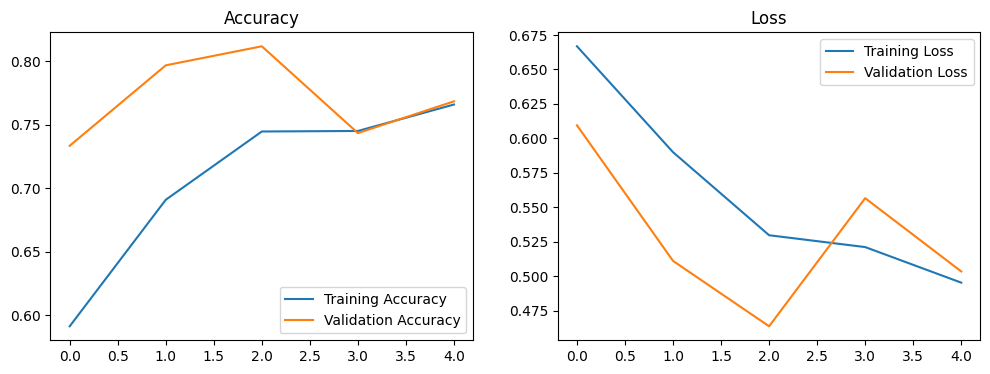

In [130]:
import matplotlib.pyplot as plt

# Plot the accuracy and loss curves
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()

# Plot the training history
plot_history(history)


Training model with {'learning_rate': 0.001, 'num_filters': 32, 'dense_units': 64}
Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.6167 - loss: 0.6591 - val_accuracy: 0.7617 - val_loss: 0.5199
Epoch 2/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7167 - loss: 0.5741 - val_accuracy: 0.7717 - val_loss: 0.4985
Epoch 3/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.7527 - loss: 0.5191 - val_accuracy: 0.7867 - val_loss: 0.4890
Epoch 4/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7577 - loss: 0.5008 - val_accuracy: 0.7950 - val_loss: 0.4755
Epoch 5/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.7851 - loss: 0.4763 - val_accuracy: 0.7617 - val_loss: 0.5031
Training model with {'learning_rate': 0.0001, 'num_filters': 64, 'dense_units': 128}
Epoch 1/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.6298 - loss: 0.6446 - val_accuracy: 0.7883 - val_loss: 0.4906
Epoch 2/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.7316 - loss: 0.5500 - val_accuracy: 0.7850 - val_loss: 0.4765
Epoch 3/5
150/150 ━━━━━━━━━━━

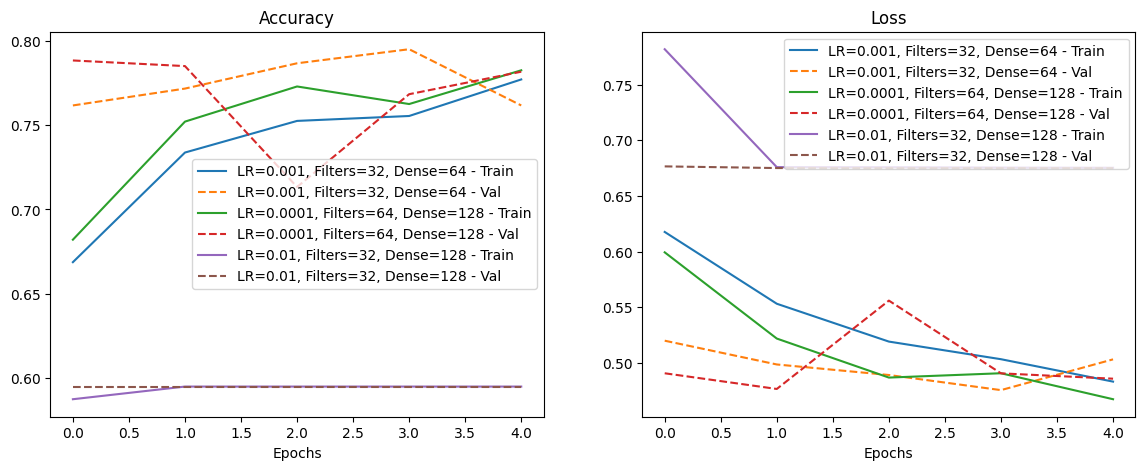

In [131]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt

# Function to build the model with different hyperparameters
def create_tuned_model(input_shape=(64, 64, 3), learning_rate=0.001, num_filters=32, dense_units=64):
    model = models.Sequential()

    # First Conv Layer
    model.add(layers.Conv2D(num_filters, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Second Conv Layer with double the filters
    model.add(layers.Conv2D(num_filters * 2, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten
    model.add(layers.Flatten())

    # Dense Layer with adjustable units
    model.add(layers.Dense(dense_units, activation='relu'))

    # Output Layer
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile the model with the adjustable learning rate
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Define a function to plot training and validation accuracy
def plot_history(histories, params):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    for history, label in zip(histories, params):
        axes[0].plot(history.history['accuracy'], label=f'{label} - Train')
        axes[0].plot(history.history['val_accuracy'], '--', label=f'{label} - Val')
        axes[1].plot(history.history['loss'], label=f'{label} - Train')
        axes[1].plot(history.history['val_loss'], '--', label=f'{label} - Val')

    axes[0].set_title('Accuracy')
    axes[1].set_title('Loss')
    for ax in axes:
        ax.set_xlabel('Epochs')
        ax.legend()

    plt.show()

# Prepare the dataset as you have done earlier (smaller image size, reduced batch size)
# Let's assume train_generator and val_generator are already defined as per your earlier code

# Experiment with different hyperparameters
params = [
    {'learning_rate': 0.001, 'num_filters': 32, 'dense_units': 64},
    {'learning_rate': 0.0001, 'num_filters': 64, 'dense_units': 128},
    {'learning_rate': 0.01, 'num_filters': 32, 'dense_units': 128}
]

histories = []

for param in params:
    print(f'Training model with {param}')
    model = create_tuned_model(
        learning_rate=param['learning_rate'], 
        num_filters=param['num_filters'], 
        dense_units=param['dense_units']
    )

    # Train the model
    history = model.fit(
        train_generator, 
        validation_data=val_generator, 
        epochs=5  # Small number of epochs for demonstration
    )
    
    # Store the history for plotting
    histories.append(history)

# Visualize the results
plot_history(histories, [f"LR={p['learning_rate']}, Filters={p['num_filters']}, Dense={p['dense_units']}" for p in params])


In [133]:
import os
import pandas as pd

# Path to the test image directory
test_img_path = '/kaggle/input/histopathologic-cancer-detection/test'

# Create a dataframe of test image filenames
test_img_files = os.listdir(test_img_path)

# Create a DataFrame with 'id' column containing test image filenames (without .tif extension)
test_df = pd.DataFrame(test_img_files, columns=['id'])
test_df['id'] = test_df['id'].str.replace('.tif', '')  # Remove '.tif' extension

# Check the first few rows
test_df.head()



,id
0,a7ea26360815d8492433b14cd8318607bcf99d9e
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62


In [134]:
# Prepare a subset of 100 test images
test_subset_df = test_df.sample(100, random_state=42)  # Randomly sample 100 test images


In [136]:
# Add the '.tif' extension back to the test image IDs
test_subset_df['id'] = test_subset_df['id'] + '.tif'

# Now it should work without the warning


In [139]:
# Train the model with the best hyperparameters
best_model = create_tuned_model(learning_rate=0.001, num_filters=32, dense_units=64)

# Train the model on the training data
best_model.fit(train_generator, validation_data=val_generator, epochs=5)


Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.6370 - loss: 0.6305 - val_accuracy: 0.6883 - val_loss: 0.6006
Epoch 2/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7391 - loss: 0.5491 - val_accuracy: 0.7683 - val_loss: 0.4813
Epoch 3/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.7590 - loss: 0.5034 - val_accuracy: 0.7933 - val_loss: 0.4718
Epoch 4/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.7812 - loss: 0.4653 - val_accuracy: 0.7583 - val_loss: 0.5097
Epoch 5/5
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7829 - loss: 0.4699 - val_accuracy: 0.7717 - val_loss: 0.4900


In [140]:
# Save the best model to a file
best_model.save('best_model.h5')


In [141]:
# Check the directory for saved model files
import os
for file in os.listdir("/kaggle/working/"):
    print(file)


my_dir
untitled_project
.virtual_documents
best_model.h5


In [142]:
# Load the model using the correct path
best_model = load_model('/kaggle/working/best_model.h5')


# Testing the submission

In [144]:
# Test Image Data Generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a test generator
test_generator = test_datagen.flow_from_dataframe(
    test_subset_df, 
    directory=test_img_path, 
    x_col='id', 
    y_col=None,  # No labels in test set
    target_size=(64, 64),  # Same size used for training
    batch_size=1,          # Batch size of 1 to make predictions one at a time
    class_mode=None,       # No labels
    shuffle=False          # Keep the order of images consistent
)

# Make predictions on the test subset
test_predictions = best_model.predict(test_generator, steps=len(test_generator), verbose=1)

# Convert predictions to binary labels (0 or 1)
test_predictions_binary = (test_predictions > 0.5).astype(int)

# Add predictions to the test subset dataframe
test_subset_df['label'] = test_predictions_binary

# Prepare the submission file (as per Kaggle competition format)
submission_df = test_subset_df[['id', 'label']]

# Save the submission file
submission_df.to_csv('/kaggle/working/submission.csv', index=False)


Found 100 validated image filenames.
 66/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


# Creating the predicitons for Submissions after the test

In [146]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# Path to the test image directory
test_img_path = '/kaggle/input/histopathologic-cancer-detection/test'

# Create a dataframe of test image filenames
test_img_files = os.listdir(test_img_path)

# Create a DataFrame with 'id' column containing test image filenames (without .tif extension)
test_df = pd.DataFrame(test_img_files, columns=['id'])
test_df['id'] = test_df['id'].str.replace('.tif', '')  # Remove '.tif' extension

# Add the '.tif' extension back to the test image IDs for later use in the generator
test_df['id'] = test_df['id'] + '.tif'

# Test Image Data Generator (for normalization)
test_datagen = ImageDataGenerator(rescale=1./255)
# Create a test generator for all images
test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    directory=test_img_path, 
    x_col='id', 
    y_col=None,  # No labels in test set
    target_size=(64, 64),  # Same size used for training
    batch_size=32,         # Use a batch size that fits your memory
    class_mode=None,       # No labels
    shuffle=False          # Keep the order of images consistent
)

# Load the best model
best_model = load_model('/kaggle/working/best_model.h5')  # Make sure to use the correct path

# Make predictions on all test images
test_predictions = best_model.predict(test_generator, steps=len(test_generator), verbose=1)

# Convert predictions to binary labels (0 or 1)
test_predictions_binary = (test_predictions > 0.5).astype(int)

# Prepare submission dataframe
submission_df = pd.DataFrame({
    'id': test_df['id'].str.replace('.tif', ''),  # Remove '.tif' extension again for submission
    'label': test_predictions_binary.flatten()    # Flatten the predictions to match the submission format
})

# Save the submission file in CSV format
submission_df.to_csv('submission.csv', index=False)


Found 57458 validated image filenames.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 221s 123ms/step


# Results

Given that the model was only trained using 2400 training samples and 600 validation samples, the score recieved is quite good. The main limitation was not having the computing power to do a much more comprehensive model. I tried that several times but the notebook either timed out or ran out of memory. Having access to a larger computer and GPU would allow to use a much larger training set and would yield better results.